# Predict Future Sales

## Data exploration and cleaning:

Lets begin by looking at all the files we have and making ourselves familiar with what data we have


### Imports:

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_files = os.listdir("data")
for index, p in enumerate(data_files):
    print(f"[{index}] {p}")

[0] items.csv
[1] item_categories.csv
[2] sales_train.csv
[3] sample_submission.csv
[4] shops.csv
[5] test.csv


In [3]:
# load all the data
train = pd.read_csv("data/sales_train.csv")
test = pd.read_csv("data/test.csv", index_col="ID")
item_info = pd.read_csv("data/items.csv")
item_catgs = pd.read_csv("data/item_categories.csv", index_col="item_category_id")
shop_info = pd.read_csv("data/shops.csv", index_col="shop_id")

Lets look at the distribution of some columns and see if we can spot any useful information

Text(0, 0.5, 'Activity')

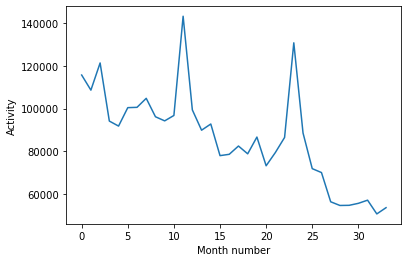

In [4]:
# plot distribution of activity every month
plt.plot(train["date_block_num"].value_counts().sort_index())
plt.xlabel("Month number")
plt.ylabel("Activity")

In [5]:
# lets look at the spikes in the data and find out which months they correspond to
train["date_block_num"].value_counts().sort_values(ascending=False).iloc[:2].index

Int64Index([11, 23], dtype='int64')

It looks like there are spikes in activity in the months of 11 and and 23 which corresponds to the month of december in the years of 2013 and 2014,
so the spikes are probably due to the holiday season. Lets keep this in mind and add the month of year to our data later, since it can influence the sales by alot.
It also seems like the activity is declining steadily, which could pose as a problem for the company in the future.

Lets plot the distribution of prices and sales to see if there are any outliers

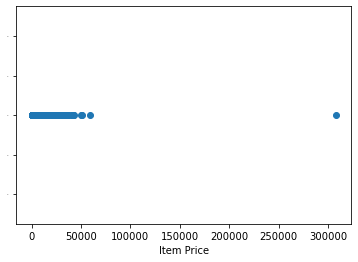

In [6]:
# plot price distribution
plt.scatter(train["item_price"].unique(), np.ones_like(train["item_price"].unique()))
plt.xlabel("Item Price")
plt.tick_params(axis="y", labelsize=0)

There seems to be an outlier that is much more expensive than the other values, lets remove this item for the sake of our model.

In [7]:
train = train[train["item_price"] < 100_000]

Some data entries have negative values for the sales count,
lets investigate and try to find out what these could mean.

In [8]:
ngt_sales = train[train["item_cnt_day"] <= 0]
print(f"{len(ngt_sales)} values that are <= 0")
ngt_sales

7356 values that are <= 0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


It could be that these values are refunds of purchases that were made before. Lets check if that could be the case.

In [9]:
def check_refunds(df):
    """check if our hypothesis is true"""
    hp_true = 0
    df["date"] = pd.to_datetime(df["date"], format=r"%d.%m.%Y")
    df.sort_values(by="date", inplace=True)
    ngt_sales = df[df["item_cnt_day"] <= 0]
    # see if there was a sale of that item in the previous 2 weeks before the ngt sale
    timespan = datetime.timedelta(days=7)
    for index, row in tqdm(ngt_sales.iterrows(), total=len(ngt_sales), desc="Checking Hypothesis", colour="red"):
        # match items with same shop id, item id, sales count that is <= the suspected refund
        # and where sale date is at most 1 weeks before the suspected refund
        same_item_shop = (df["shop_id"] == row["shop_id"]) & (df["item_id"] == row["item_id"])
        item_cnt_checks_out = (df["item_cnt_day"] >= -row["item_cnt_day"])
        timespan_checks_out = ((row["date"] - timespan) <= df["date"]) & (df["date"] <= row["date"])
        if (timespan_checks_out & same_item_shop & item_cnt_checks_out).any():
            hp_true += 1
    return hp_true, len(ngt_sales)

In [10]:
check_hypothesis = False
if check_hypothesis:
    hp_true, total_ngt = check_refunds(train)
    print()
    print(f"Hypothesis checks out {round((hp_true / total_ngt) * 100)}% of the time")

Since our hypothesis checks out almost 80% of the time (in about 80% of cases the item was bought 7 days before the negative entry), we can assume that the negative sale values are refunds.
Since refunds are not relevant for the item count the shops must have in stock, since they have to have them in stock, regardless of whether they are refunds or not, we can ignore these entries and drop them from our df.

In [11]:
# drop refunds
train = train[train["item_cnt_day"] > 0]

Lets look for outliers in terms of sales, maybe there are days where there were much more sales than usual, which could mess with our model.

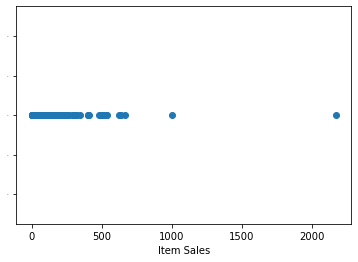

In [12]:
# # plot sale count distribution
plt.scatter(train["item_cnt_day"].unique(), np.ones_like(train["item_cnt_day"].unique()))
plt.xlabel("Item Sales")
plt.tick_params(axis="y", labelsize=0)

Lets drop the obvious outliers

In [13]:
# drop outlier-entries with sale count per day over 1k
train = train[(train["item_cnt_day"] < 1_000)]

Since we want to predict a whole months' sales, lets sum up the values of a whole month into combinations of item_id, shop_id combinations for that month

In [14]:
from itertools import product
from time import time

start = time()
print("Building Matrix...")
matrix = np.array(list(product(
    train["date_block_num"].unique(), 
    train["shop_id"].unique(),
    train["item_id"].unique())))
matrix = pd.DataFrame(data=matrix, columns=["date_block_num", "shop_id", "item_id"])
print(f"Building Matrix took {round(time() - start)} seconds.")

Building Matrix...
Building Matrix took 49 seconds.


Now lets add the sale count data to the matrix

In [15]:
sales_by_month = train.groupby(by=["date_block_num", "shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
matrix = matrix.merge(sales_by_month, how="left", on=["date_block_num", "shop_id", "item_id"])
matrix.rename(columns={"item_cnt_day" : "item_cnt_month"}, inplace=True)
matrix["item_cnt_month"].fillna(0, inplace=True)
matrix.sort_values(by=["date_block_num", "shop_id", "item_id"], inplace=True)

Adding month of year (January, February, ...) and whether or not the store is in moscow (13 shops are in moscow, which is significant enough to add) while all other stores classied as "not in moscow" because there are always at most 4 stores per city.

In [16]:
# add month that we discussed earlier
matrix["month_of_year"] = (matrix["date_block_num"] % 12) + 1
# get all shops that are not in moscow and replace their feature with the number 0
shop_info[["city", "shop_name"]] = shop_info["shop_name"].str.split(' ', 1, expand=True)
other_cities_ctg = shop_info[shop_info['city'].map(shop_info['city'].value_counts()) < 5]["city"].unique()
shop_info["city"].replace(to_replace={city: 0 for city in other_cities_ctg}, inplace=True)
# get all shops that are in moscow and set their feature to 1
shop_info["city"].replace(to_replace={"Москва" : 1}, inplace=True)
# rename column from city to is_in_moscow
shop_info.rename(columns={"city": "is_in_moscow"}, inplace=True)
# drop shop_name column
shop_info.drop("shop_name", axis=1, inplace=True)
# add is_in_moscow to matrix
matrix = matrix.merge(shop_info,on="shop_id", how="left")
test = test.merge(shop_info,on="shop_id", how="left")

Now lets add the item prices to the matrix. First lets look at if the price is changing alot (e.g. because of discounts) which could change consumer behaviour alot

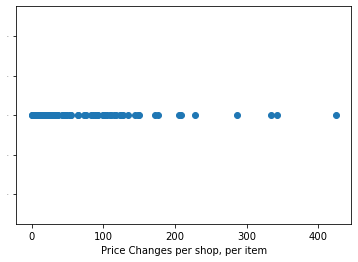

In [17]:
# group prices for every shop_id and item_id combination and plot the distribution of price changes per shop, per item
different_prices = train.groupby(by=["shop_id", "item_id"])["item_price"].unique().reset_index()
price_chgs = different_prices["item_price"].map(lambda x: len(x) - 1).unique()
plt.scatter(price_chgs, np.ones_like(price_chgs))
plt.xlabel("Price Changes per shop, per item")
plt.tick_params(axis="y", labelsize=0)

Now we know that there are alot of price changes happening, but there are also some  stores which have alot of promotions per item, making it hard for us to set a single price variable per shop/item combination.
Because of this, lets how the same distribution looks when we also categorise by month.

Text(0, 0.5, 'Shop Count (1 : 100.000)')

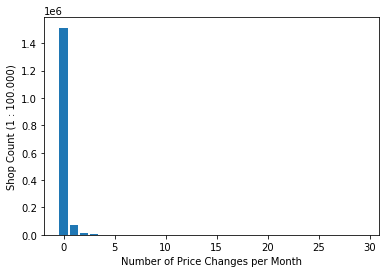

In [18]:
monthly_prices = train.groupby(by=["shop_id", "item_id", "date_block_num"])["item_price"].unique().reset_index()
monthly_price_chgs = monthly_prices["item_price"].map(lambda x: len(x) - 1)
monthly_price_chgs_unq = monthly_price_chgs.value_counts()
plt.bar(x=monthly_price_chgs_unq.index, height=monthly_price_chgs_unq)
plt.xlabel("Number of Price Changes per Month", fontsize=10)
plt.ylabel("Shop Count (1 : 100.000)", fontsize=10)

As we can see almost all price changes are in the range (0-5) per month, it would be valuable to look at these price changes and see how high the discount/increase was.

In [19]:
changed = monthly_prices["item_price"].loc[monthly_prices["item_price"].map(len) > 1]
def get_change_sizes(arr):
    """Gets sizes of price discounts/increases"""
    sizes = []
    for month in arr:
        for i in range(len(month)-1):
            # append relative price change ((p2 - p1) / p2) x 100 where p1=previous price and p2=changed price
            sizes.append(int(((month[i+1] - month[i]) / month[i]) * 100))
    sizes = pd.Series(np.array(sizes))
    return sizes

Text(0, 0.5, 'Occurrances')

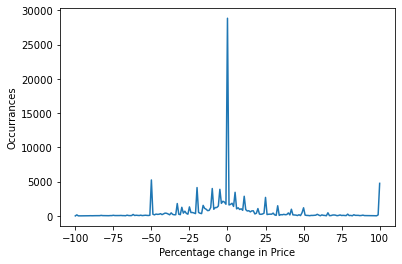

In [20]:
price_chg_sizes = get_change_sizes(changed)
val_cnts = price_chg_sizes.value_counts().sort_index().loc[-100:100]
plt.plot(val_cnts.index, val_cnts)
plt.xlabel("Percentage change in Price")
plt.ylabel("Occurrances")

It looks like most price discounts/increases are between -50% and 50% with a huge spike at 100% price increase (which means the price was doubled). For our data we will experiment with both the median and the mean price of the chosen month. And later for the testing data we will use the last available price of the item that we observed.

In [21]:
# add prices to test data
different_prices["item_price"] = different_prices["item_price"].map(lambda x: x[-1])
test = test.merge(different_prices, how="left", on=["shop_id", "item_id"])
# add prices to train data
eval_method = np.mean # or "np.median"
monthly_prices["item_price"] = monthly_prices["item_price"].map(eval_method)
matrix = pd.merge(matrix, monthly_prices, how="left", on=["shop_id", "item_id", "date_block_num"])

Adding month that we discussed earlier to test data aswell

In [22]:
test["date_block_num"] = matrix["date_block_num"].max() + 1
test["month_of_year"] = (test["date_block_num"] % 12) + 1

It might be very valuable for our model if it knows the sales of the shop/ item combination in the last 3 months. Lets add it to our datapoints.

In [23]:
# add the 3 previous months
month_lag_count = 3

train_data = matrix[matrix["date_block_num"] >= month_lag_count].copy()
item_sales_cnt = matrix[["shop_id", "item_id", "date_block_num", "item_cnt_month"]].copy()

# loop over month lag and add it to df
for i in tqdm(range(1, month_lag_count+1)):
    new_column_name = lambda x: f"lag_month_sales{x}"
    item_sales_cnt.rename(columns={"item_cnt_month" if i == 1 else new_column_name(i-1): new_column_name(i)}, inplace=True)
    item_sales_cnt["date_block_num"] = item_sales_cnt["date_block_num"] + 1
    train_data = train_data.merge(item_sales_cnt, on=["shop_id", "item_id", "date_block_num"], how="left")

    test = test.merge(item_sales_cnt, on=["shop_id", "item_id", "date_block_num"], how="left")
    
# fill na values with 0 since they mean that the item was not sold in the lag month
train_data.fillna(0, inplace=True)
test.fillna(0, inplace=True)

100%|██████████| 3/3 [01:47<00:00, 35.98s/it]


# Saving data
Now the only thing we have to do is to save our data, so we can use it in our model.

In [24]:
# sort columns of dfs
train_data = train_data.reindex(sorted(train_data.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)
# save the data
save_data = True
if save_data:
    train_data.to_csv("train_data.csv", index=False)
    test.to_csv("test.csv", index=False)